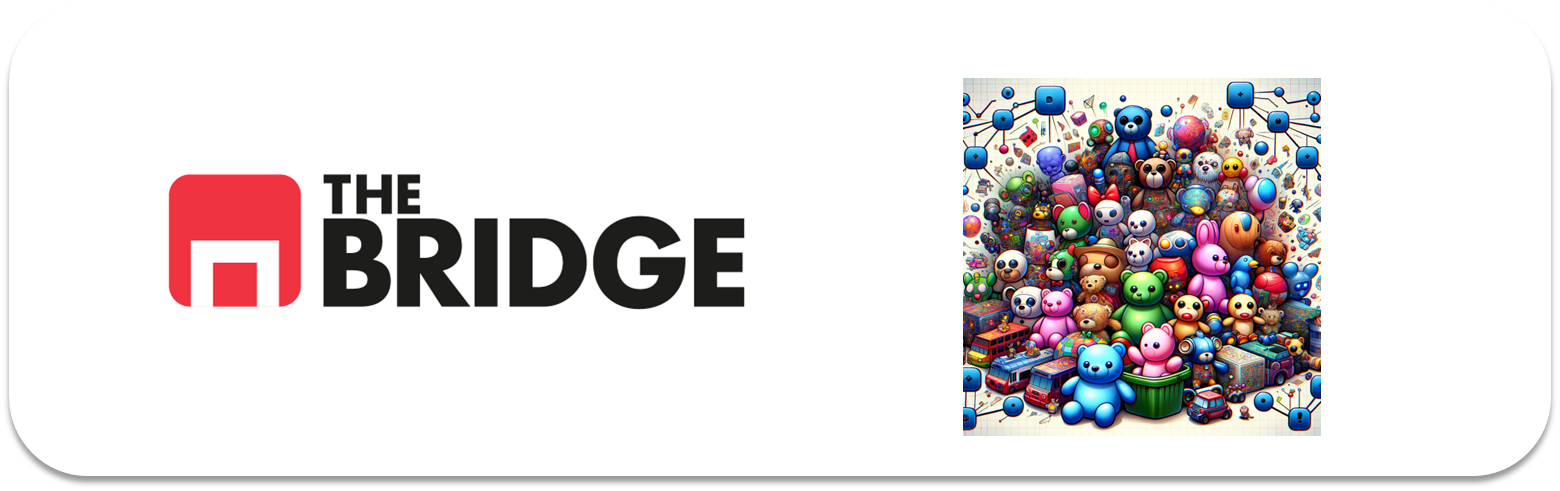

## PRACTICA OBLIGATORIA: **K-Means Clustering**

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado sobre imágenes para practicar con el algoritmo k-means. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image
import os
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

## **#1**

Vamos a trabajar con un dataset también entre los "clásicos" (aunque a veces menos conocido) que es el de rostros Olivetti. Este dataset contiene 400 imágenes en escala de grises de 64 × 64 píxeles de rostros.   


Como en otros datasets de imágenes, estás están "aplanadas" de forma que cada pixel es una feature y por cada imagen hay $64\times 64 = 4096$ features.  

Se fotografiaron 40 personas diferentes (10 veces cada una) y esas fotografías se recogen en el dataset.  

La tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen, pero nosotros lo vamos a hacer de forma no supervisada. 



### #1.1


Carga el conjunto de datos usando la función `sklearn.datasets.fetch_olivetti_faces()`. Recuerda que se carga un "diccionario". Muestra su descripción acudiendo a la clave "DESCR".

In [ ]:
data_olivetti = fetch_olivetti_faces(shuffle=True, random_state=42)

print(data_olivetti.DESCR)

X = data_olivetti.data    
y = data_olivetti.target
images = data_olivetti.images

print(f"\nForma de la matriz de datos: {X.shape}")
print(f"Número de imágenes: {len(images)}")

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\danma\scikit_learn_data
.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for s

### #1.2 

Aunque no lo vas a usar hasta el final de la práctica, muestra el target. Luego cargalo todo en un mismo dataframe (tendrás que añadir el target) y obtén otro dataset con todas las imagenes reordenadas aleatoriamente (emplea por ejemplo el método `sample` del dataframe o el método que tú quieras)

In [ ]:
print("Target original (primeras 20 imágenes):")
print(data_olivetti.target[:20])

df_faces = pd.DataFrame(data_olivetti.data)

df_faces['person_id'] = data_olivetti.target

df_faces_shuffled = df_faces.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nPrimeras filas del DataFrame mezclado:")
df_faces_shuffled.head()

Target original (primeras 20 imágenes):
[20 28  3 21  9  8 32  9 26 12  0 36  5  7 13  4 27 37 23 38]

Primeras filas del DataFrame mezclado:


,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,person_id
0,0.252066,0.231405,0.276859,0.417355,0.433884,0.669421,0.834711,0.859504,0.871901,0.871901,...,0.508264,0.268595,0.140496,0.165289,0.169421,0.173554,0.181818,0.173554,0.177686,18
1,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554,0
2,0.723140,0.710744,0.714876,0.731405,0.735537,0.752066,0.772727,0.793388,0.814050,0.834711,...,0.904959,0.549587,0.409091,0.491736,0.487603,0.471074,0.483471,0.475207,0.475207,5
3,0.652893,0.690083,0.677686,0.690083,0.714876,0.743802,0.747934,0.735537,0.710744,0.681818,...,0.152893,0.140496,0.086777,0.111570,0.173554,0.243802,0.223140,0.260331,0.309917,22
4,0.409091,0.590909,0.657025,0.681818,0.694215,0.731405,0.760331,0.785124,0.776860,0.785124,...,0.276859,0.314050,0.268595,0.247934,0.256198,0.264463,0.252066,0.276859,0.285124,22


### #1.3

Vamos a dividir en train y test, pero OJO RECUERDA QUE EN LOS PROBLEMAS NO SUPERVISADOS NO HAY SPLIT (porque no hay target), aquí lo hacemos para poder comparar posteriormente el clustering con la clasificación (ya que es uan práctica formativa).

Por tanto, divídelo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de pruebas (80-10-10). Dado que el conjunto de datos es bastante pequeño, emplea un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto (estratificando por la columna que contenga el target)

NOTA: No hemos hecho hasta ahora la separación en tres sets, investiga por tu cuenta o bien haz primero un split 90-10 y luego otro split 89-11 sobre el de 80 (para que de los números aproximados), por ejemplo.

In [8]:
X = df_faces_shuffled.drop(columns=['person_id'])
y = df_faces_shuffled['person_id']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Entrenamiento (80%): {X_train.shape[0]} imágenes")
print(f"Validación    (10%): {X_val.shape[0]} imágenes")
print(f"Pruebas       (10%): {X_test.shape[0]} imágenes")

Entrenamiento (80%): 320 imágenes
Validación    (10%): 40 imágenes
Pruebas       (10%): 40 imágenes


### #1.4

Crea los pares X,y para train, validation y test.

In [ ]:
X_train = X_train.values
y_train = y_train.values

X_val = X_val.values
y_val = y_val.values

X_test = X_test.values
y_test = y_test.values

print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Val:   X={X_val.shape}, y={y_val.shape}")
print(f"Test:  X={X_test.shape}, y={y_test.shape}")

Train: X=(320, 4096), y=(320,)
Val:   X=(40, 4096), y=(40,)
Test:  X=(40, 4096), y=(40,)


Utiliza la siguiente función para visualizar alguna de las caras (observa que tienes que dar la X y la y, usa iloc en ambos datasets)

In [11]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

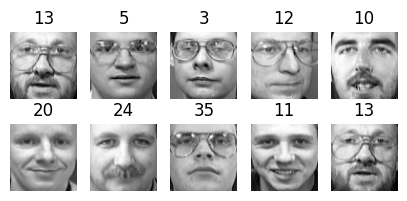

In [12]:
plot_faces(X_train[:10], y_train[:10], n_cols=5)

### #1.5

Para acelerar las cosas, reduciremos la dimensionalidad de los datos utilizando PCA (técnica que veremos en el siguiente sprint). Modifica la siguiente celda de forma que las X se correspondan con las que has utilizado en el ejercicio anterior.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(0.99, random_state=42)

X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)    # Usamos X_val que definimos en el split anterior
X_test_pca = pca.transform(X_test)

print(f"Dimensiones originales: {X_train.shape[1]}")
print(f"Dimensiones tras PCA: {pca.n_components_}")
print(f"Reducción del: {round((1 - pca.n_components_/4096)*100, 2)}%")

Dimensiones originales: 4096
Dimensiones tras PCA: 220
Reducción del: 94.63%


### 1.6

Aquí viene la parte del león. A continuación, agrupa las imágenes utilizando K-Means sobre el dataset de train reducido en el ejercicio anterior. Emplea el método del máximo de score de silueta para obtener el mejor k, probando con K de 5 en 5 hasta 150. ¿Cuál es el k que proporciona el mejor score de silueta? NOTA: Emplea todas las features (no hace falta seleccionar, y ya están escaladas entre 0 y 1)

In [ ]:
k_range = range(5, 151, 5)
silhouette_scores = []

print("Calculando scores de silueta...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_train_pca)
    
    score = silhouette_score(X_train_pca, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"K={k} -> Silhouette Score: {score:.4f}")

best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

print(f"\nRESULTADO")
print(f"El mejor número de clústeres es K={best_k} con un score de {best_score:.4f}")

Calculando scores de silueta...
K=5 -> Silhouette Score: 0.1114
K=10 -> Silhouette Score: 0.0990
K=15 -> Silhouette Score: 0.0993
K=20 -> Silhouette Score: 0.1177
K=25 -> Silhouette Score: 0.1369
K=30 -> Silhouette Score: 0.1404
K=35 -> Silhouette Score: 0.1542
K=40 -> Silhouette Score: 0.1571
K=45 -> Silhouette Score: 0.1660
K=50 -> Silhouette Score: 0.1656
K=55 -> Silhouette Score: 0.1738
K=60 -> Silhouette Score: 0.1818
K=65 -> Silhouette Score: 0.1859
K=70 -> Silhouette Score: 0.1946
K=75 -> Silhouette Score: 0.1989
K=80 -> Silhouette Score: 0.1989
K=85 -> Silhouette Score: 0.2120
K=90 -> Silhouette Score: 0.2102
K=95 -> Silhouette Score: 0.2143
K=100 -> Silhouette Score: 0.2167
K=105 -> Silhouette Score: 0.2170
K=110 -> Silhouette Score: 0.2222
K=115 -> Silhouette Score: 0.2188
K=120 -> Silhouette Score: 0.2073
K=125 -> Silhouette Score: 0.2162
K=130 -> Silhouette Score: 0.2103
K=135 -> Silhouette Score: 0.2134
K=140 -> Silhouette Score: 0.2141
K=145 -> Silhouette Score: 0.2145
K=

### #1.7

Repite el ejercio anterior empleando ahora el método del codo de Inercia. ¿Sale algo más concluyente o que refuerce el anterior resultado?

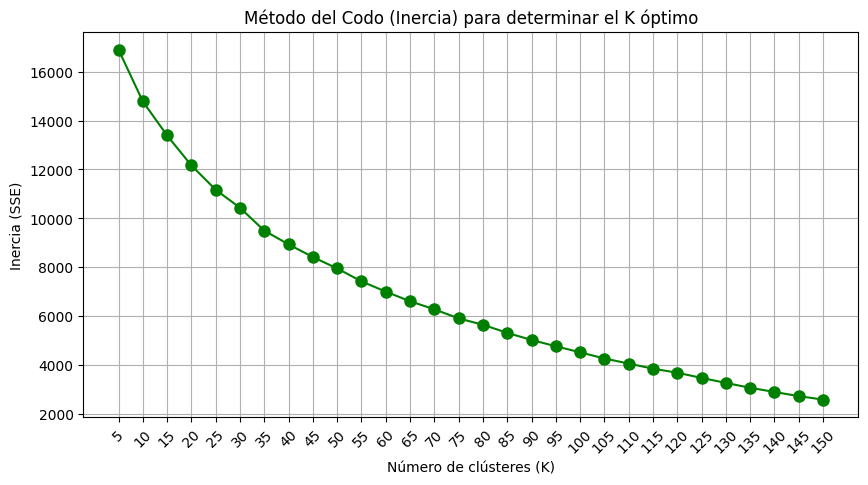

In [ ]:
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_train_pca)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, inertias, 'go-', markersize=8)
plt.xlabel("Número de clústeres (K)")
plt.ylabel("Inercia (SSE)")
plt.title("Método del Codo (Inercia) para determinar el K óptimo")
plt.xticks(k_range, rotation=45)
plt.grid(True)
plt.show()

### #1.8

Quédate con el k obtenido con el método del score de silueta y asigna el modelo con ese k a una variable `best_model`

In [ ]:
print(f"Entrenando el modelo final con K = {best_k}...")

best_model = KMeans(n_clusters=best_k, n_init=20, random_state=42)
best_model.fit(X_train_pca)

train_clusters = best_model.labels_

print("Modelo 'best_model' listo y entrenado.")

Entrenando el modelo final con K = 110...
Modelo 'best_model' listo y entrenado.


### #1.9

Haz una valoración del método de clustering para el K elegido. Para ello crea un programa que recorra la lista de etiquetas dadas por "best_model" y que, haciendo uso de la función que ya te hemos proporcionado, pinte las caras asignadas a los 10 primeros clústeres. Ojo tendrás que hacer una pequeña adaptación porque las features de entrenamiento no son las features reales (son una "transformación" de estas) y si pasas el X de entrenamiento no verás nada. ¿Ves caras similares?

Visualizando Clúster 0 (Total imágenes: 3)


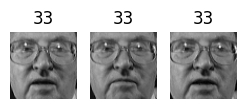

Visualizando Clúster 1 (Total imágenes: 2)


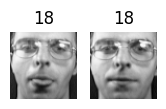

Visualizando Clúster 2 (Total imágenes: 3)


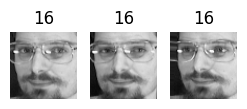

Visualizando Clúster 3 (Total imágenes: 5)


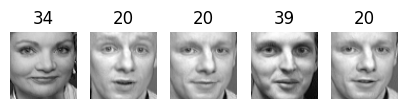

Visualizando Clúster 4 (Total imágenes: 3)


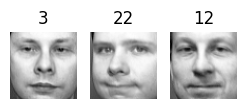

Visualizando Clúster 5 (Total imágenes: 3)


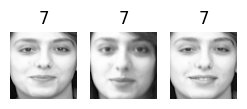

Visualizando Clúster 6 (Total imágenes: 4)


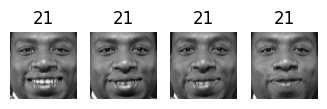

Visualizando Clúster 7 (Total imágenes: 4)


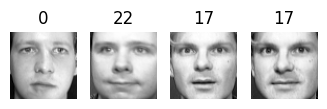

Visualizando Clúster 8 (Total imágenes: 4)


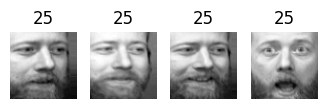

Visualizando Clúster 9 (Total imágenes: 9)


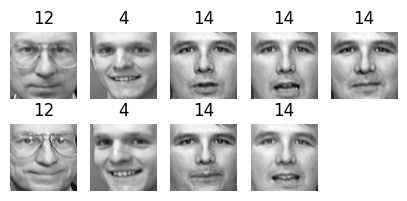

In [ ]:
for cluster_id in range(10):
    in_cluster = (best_model.labels_ == cluster_id)
    
    faces_in_cluster = X_train[in_cluster]
    real_labels = y_train[in_cluster]
    
    if len(faces_in_cluster) > 0:
        print(f"Visualizando Clúster {cluster_id} (Total imágenes: {len(faces_in_cluster)})")
        # Usamos la función proporcionada anteriormente
        plot_faces(faces_in_cluster, real_labels)
    else:
        print(f"El clúster {cluster_id} está vacío.")

## **#2**


### #2.1


Continuando con el conjunto de datos de caras Olivetti, entrena un clasificador para predecir qué persona está representada en cada imagen, y evalúalo en el conjunto de validación. Utiliza un RandomForest con 150 submodelos o estimadores (y el resto de hiperparámetros déjalos a su valor por defecto)

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42)

rf_clf.fit(X_train_pca, y_train)

y_pred_val = rf_clf.predict(X_val_pca)

accuracy = accuracy_score(y_val, y_pred_val)

print(f"Precisión (Accuracy) en el conjunto de validación: {accuracy * 100:.2f}%")

Precisión (Accuracy) en el conjunto de validación: 97.50%


### #2.2

Utiliza K-Means como una herramienta de reducción de dimensionalidad y entrena un clasificador en el conjunto reducido. Para ello emplea el método transform de manera que ahora las features de entrada sean las distancias de cada punto a los centroides del modelo "best_model" de la parte anterior. Por ejemplo:
```python
X_train_reduced = best_model.transform(X_train_pca) 
```


Ojo lo tienes que aplicar a todos los datasets. Luego vuelve a entrenar un RandomForest sobre este dataset y evalualo contra el dataset de validacion.

In [ ]:
X_train_cluster_dist = best_model.transform(X_train_pca)
X_val_cluster_dist   = best_model.transform(X_val_pca)
X_test_cluster_dist  = best_model.transform(X_test_pca)

rf_clf_clusters = RandomForestClassifier(n_estimators=150, random_state=42)
rf_clf_clusters.fit(X_train_cluster_dist, y_train)

y_pred_cluster_val = rf_clf_clusters.predict(X_val_cluster_dist)
accuracy_cluster = accuracy_score(y_val, y_pred_cluster_val)

print(f"Dimensiones de entrada actuales: {X_train_cluster_dist.shape[1]}")
print(f"Precisión usando distancias a clústeres: {accuracy_cluster * 100:.2f}%")

Dimensiones de entrada actuales: 110
Precisión usando distancias a clústeres: 80.00%


### #2.3 EXTRA VOLUNTARIO

Busca el número de clusters k que generen un algoritmo kmeans que a su vez sus distancias a los centroides sean las features de un clasificador RandomForest y que permita al clasificador obtener el mejor rendimiento: ¿Qué rendimiento puedes alcanzar? (en terminos de Accuracy)

In [ ]:
k_search_range = range(20, 201, 20)
results = {}

print("Iniciando búsqueda del K óptimo para el clasificador...")

for k in k_search_range:
    kmeans_search = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans_search.fit(X_train_pca)
    
    X_train_dist = kmeans_search.transform(X_train_pca)
    X_val_dist   = kmeans_search.transform(X_val_pca)
    
    rf_search = RandomForestClassifier(n_estimators=150, random_state=42)
    rf_search.fit(X_train_dist, y_train)
    
    acc = accuracy_score(y_val, rf_search.predict(X_val_dist))
    results[k] = acc
    print(f"K={k} -> Accuracy en Validación: {acc:.4f}")
    
best_k_for_rf = max(results, key=results.get)
best_acc = results[best_k_for_rf]

print(f"\nRESULTADO FINAL")
print(f"Mejor número de clústeres como features: K={best_k_for_rf}")
print(f"Rendimiento máximo alcanzado (Accuracy): {best_acc * 100:.2f}%")

Iniciando búsqueda del K óptimo para el clasificador...
K=20 -> Accuracy en Validación: 0.6250
K=40 -> Accuracy en Validación: 0.7750
K=60 -> Accuracy en Validación: 0.8250
K=80 -> Accuracy en Validación: 0.8500
K=100 -> Accuracy en Validación: 0.7750
K=120 -> Accuracy en Validación: 0.8250
K=140 -> Accuracy en Validación: 0.8250
K=160 -> Accuracy en Validación: 0.8250
K=180 -> Accuracy en Validación: 0.8500
K=200 -> Accuracy en Validación: 0.8250

RESULTADO FINAL
Mejor número de clústeres como features: K=80
Rendimiento máximo alcanzado (Accuracy): 85.00%
